In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
         0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
         0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_32_06 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.6
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_32_06[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 43.74662375450134 
    loop_MC 1 - time has passed: 106.42283701896667 
    loop_MC 2 - time has passed: 160.09238505363464 
    loop_MC 3 - time has passed: 211.71127009391785 
    loop_MC 4 - time has passed: 262.17951464653015 
    loop_MC 5 - time has passed: 319.75929498672485 
    loop_MC 6 - time has passed: 386.6071436405182 
    loop_MC 7 - time has passed: 440.34647846221924 
    loop_MC 8 - time has passed: 503.5389745235443 
    loop_MC 9 - time has passed: 570.2137479782104 
    loop_MC 10 - time has passed: 626.5392346382141 
    loop_MC 11 - time has passed: 680.4017345905304 
    loop_MC 12 - time has passed: 727.440064907074 
    loop_MC 13 - time has passed: 778.4104640483856 
    loop_MC 14 - time has passed: 832.3628489971161 
    loop_MC 15 - time has passed: 895.1911206245422 
    loop_MC 16 - time has passed: 950.7985019683838 
    loop_MC 17 - time has passed: 1010.6545026302338 
    loop_MC 18 - time has passed: 1067.22812104225

    loop_MC 2 - time has passed: 157.16193866729736 
    loop_MC 3 - time has passed: 194.732764005661 
    loop_MC 4 - time has passed: 253.62351775169373 
    loop_MC 5 - time has passed: 312.53117871284485 
    loop_MC 6 - time has passed: 369.2976109981537 
    loop_MC 7 - time has passed: 421.47742199897766 
    loop_MC 8 - time has passed: 470.5132610797882 
    loop_MC 9 - time has passed: 525.8750712871552 
    loop_MC 10 - time has passed: 580.2352936267853 
    loop_MC 11 - time has passed: 630.8411147594452 
    loop_MC 12 - time has passed: 678.2625703811646 
    loop_MC 13 - time has passed: 727.4511215686798 
    loop_MC 14 - time has passed: 784.1405229568481 
    loop_MC 15 - time has passed: 833.5995962619781 
    loop_MC 16 - time has passed: 898.6149749755859 
    loop_MC 17 - time has passed: 953.2660489082336 
    loop_MC 18 - time has passed: 1014.6339485645294 
    loop_MC 19 - time has passed: 1073.2386581897736 
    loop_MC 20 - time has passed: 1142.9647424221

    loop_MC 3 - time has passed: 226.9043686389923 
    loop_MC 4 - time has passed: 286.6718249320984 
    loop_MC 5 - time has passed: 340.3668658733368 
    loop_MC 6 - time has passed: 399.51639008522034 
    loop_MC 7 - time has passed: 455.5362071990967 
    loop_MC 8 - time has passed: 517.5912640094757 
    loop_MC 9 - time has passed: 582.5138618946075 
    loop_MC 10 - time has passed: 645.5961318016052 
    loop_MC 11 - time has passed: 703.3626616001129 
    loop_MC 12 - time has passed: 764.5173666477203 
    loop_MC 13 - time has passed: 828.2193114757538 
    loop_MC 14 - time has passed: 892.0266969203949 
    loop_MC 15 - time has passed: 943.48872590065 
    loop_MC 16 - time has passed: 1001.2655129432678 
    loop_MC 17 - time has passed: 1071.5087299346924 
    loop_MC 18 - time has passed: 1135.8046832084656 
    loop_MC 19 - time has passed: 1185.2543787956238 
    loop_MC 20 - time has passed: 1245.1506798267365 
    loop_MC 21 - time has passed: 1304.1083269119

    loop_MC 4 - time has passed: 293.92713260650635 
    loop_MC 5 - time has passed: 355.4771091938019 
    loop_MC 6 - time has passed: 410.3054759502411 
    loop_MC 7 - time has passed: 465.1601560115814 
    loop_MC 8 - time has passed: 502.6262798309326 
    loop_MC 9 - time has passed: 558.6961019039154 
    loop_MC 10 - time has passed: 625.9836783409119 
    loop_MC 11 - time has passed: 683.312087059021 
    loop_MC 12 - time has passed: 745.8655955791473 
    loop_MC 13 - time has passed: 803.669141292572 
    loop_MC 14 - time has passed: 859.7882442474365 
    loop_MC 15 - time has passed: 912.0744903087616 
    loop_MC 16 - time has passed: 969.1125388145447 
    loop_MC 17 - time has passed: 1025.0477776527405 
    loop_MC 18 - time has passed: 1086.0539829730988 
    loop_MC 19 - time has passed: 1137.3009462356567 
    loop_MC 20 - time has passed: 1197.8835146427155 
    loop_MC 21 - time has passed: 1263.0940976142883 
    loop_MC 22 - time has passed: 1315.623602628

    loop_MC 6 - time has passed: 411.32120537757874 
    loop_MC 7 - time has passed: 458.6474542617798 
    loop_MC 8 - time has passed: 519.0143487453461 
    loop_MC 9 - time has passed: 578.018846988678 
    loop_MC 10 - time has passed: 634.9522321224213 
    loop_MC 11 - time has passed: 693.5246970653534 
    loop_MC 12 - time has passed: 751.2764163017273 
    loop_MC 13 - time has passed: 808.5052247047424 
    loop_MC 14 - time has passed: 858.2633373737335 
    loop_MC 15 - time has passed: 915.0477514266968 
    loop_MC 16 - time has passed: 966.8708086013794 
    loop_MC 17 - time has passed: 1033.662392616272 
    loop_MC 18 - time has passed: 1088.2186970710754 
    loop_MC 19 - time has passed: 1151.4810209274292 
    loop_MC 20 - time has passed: 1212.4880192279816 
    loop_MC 21 - time has passed: 1269.0041427612305 
    loop_MC 22 - time has passed: 1336.368277311325 
    loop_MC 23 - time has passed: 1395.4919652938843 
    loop_MC 24 - time has passed: 1458.900576

    loop_MC 8 - time has passed: 502.22719383239746 
    loop_MC 9 - time has passed: 560.8333752155304 
    loop_MC 10 - time has passed: 620.9727594852448 
    loop_MC 11 - time has passed: 673.0903639793396 
    loop_MC 12 - time has passed: 726.3211801052094 
    loop_MC 13 - time has passed: 780.4127082824707 
    loop_MC 14 - time has passed: 847.7620830535889 
    loop_MC 15 - time has passed: 905.3876516819 
    loop_MC 16 - time has passed: 965.0016350746155 
    loop_MC 17 - time has passed: 1015.1840047836304 
    loop_MC 18 - time has passed: 1073.1141304969788 
    loop_MC 19 - time has passed: 1124.2157769203186 
    loop_MC 20 - time has passed: 1177.3000934123993 
    loop_MC 21 - time has passed: 1236.7054800987244 
    loop_MC 22 - time has passed: 1296.517254114151 
    loop_MC 23 - time has passed: 1350.4406743049622 
    loop_MC 24 - time has passed: 1401.8309931755066 
    loop_MC 25 - time has passed: 1460.2765583992004 
    loop_MC 26 - time has passed: 1509.958

    loop_MC 10 - time has passed: 657.1453394889832 
    loop_MC 11 - time has passed: 721.2984466552734 
    loop_MC 12 - time has passed: 771.6757266521454 
    loop_MC 13 - time has passed: 830.2827322483063 
    loop_MC 14 - time has passed: 886.9044318199158 
    loop_MC 15 - time has passed: 949.1532597541809 
    loop_MC 16 - time has passed: 1012.3785471916199 
    loop_MC 17 - time has passed: 1062.9409260749817 
    loop_MC 18 - time has passed: 1128.4992990493774 
    loop_MC 19 - time has passed: 1181.2384848594666 
    loop_MC 20 - time has passed: 1243.9693520069122 
    loop_MC 21 - time has passed: 1308.1318306922913 
    loop_MC 22 - time has passed: 1367.1535165309906 
    loop_MC 23 - time has passed: 1417.4610254764557 
    loop_MC 24 - time has passed: 1471.0318048000336 
    loop_MC 25 - time has passed: 1522.167754650116 
    loop_MC 26 - time has passed: 1567.6606895923615 
    loop_MC 27 - time has passed: 1628.664725780487 
    loop_MC 28 - time has passed: 16

    loop_MC 11 - time has passed: 660.6041610240936 
    loop_MC 12 - time has passed: 709.3795313835144 
    loop_MC 13 - time has passed: 765.7745320796967 
    loop_MC 14 - time has passed: 823.1566932201385 
    loop_MC 15 - time has passed: 875.0852463245392 
    loop_MC 16 - time has passed: 935.6390516757965 
    loop_MC 17 - time has passed: 987.4532978534698 
    loop_MC 18 - time has passed: 1035.401243686676 
    loop_MC 19 - time has passed: 1090.5564363002777 
    loop_MC 20 - time has passed: 1143.761591911316 
    loop_MC 21 - time has passed: 1193.4132273197174 
    loop_MC 22 - time has passed: 1247.9828486442566 
    loop_MC 23 - time has passed: 1302.5560381412506 
    loop_MC 24 - time has passed: 1362.514146566391 
    loop_MC 25 - time has passed: 1416.018434047699 
    loop_MC 26 - time has passed: 1471.3178217411041 
    loop_MC 27 - time has passed: 1527.8792889118195 
    loop_MC 28 - time has passed: 1581.789713382721 
    loop_MC 29 - time has passed: 1630.1

    loop_MC 13 - time has passed: 731.294839143753 
    loop_MC 14 - time has passed: 782.0050106048584 
    loop_MC 15 - time has passed: 840.2349972724915 
    loop_MC 16 - time has passed: 888.7828645706177 
    loop_MC 17 - time has passed: 940.7677481174469 
    loop_MC 18 - time has passed: 993.7911021709442 
    loop_MC 19 - time has passed: 1045.3028054237366 
    loop_MC 20 - time has passed: 1095.8807339668274 
    loop_MC 21 - time has passed: 1146.1905400753021 
    loop_MC 22 - time has passed: 1198.7163362503052 
    loop_MC 23 - time has passed: 1262.0356698036194 
    loop_MC 24 - time has passed: 1323.4069089889526 
    loop_MC 25 - time has passed: 1382.0221633911133 
    loop_MC 26 - time has passed: 1439.7034227848053 
    loop_MC 27 - time has passed: 1483.6757760047913 
    loop_MC 28 - time has passed: 1529.670420408249 
    loop_MC 29 - time has passed: 1585.1746940612793 
    loop_MC 30 - time has passed: 1641.7141082286835 
    loop_MC 31 - time has passed: 17

    loop_MC 15 - time has passed: 841.5232226848602 
    loop_MC 16 - time has passed: 892.4637331962585 
    loop_MC 17 - time has passed: 945.7400584220886 
    loop_MC 18 - time has passed: 991.7131958007812 
    loop_MC 19 - time has passed: 1041.9373877048492 
    loop_MC 20 - time has passed: 1091.0731489658356 
    loop_MC 21 - time has passed: 1152.2241291999817 
    loop_MC 22 - time has passed: 1205.2273750305176 
    loop_MC 23 - time has passed: 1262.8888874053955 
    loop_MC 24 - time has passed: 1310.901076078415 
    loop_MC 25 - time has passed: 1367.4125967025757 
    loop_MC 26 - time has passed: 1417.173274755478 
    loop_MC 27 - time has passed: 1469.8138251304626 
    loop_MC 28 - time has passed: 1517.405023097992 
    loop_MC 29 - time has passed: 1578.2951114177704 
    loop_MC 30 - time has passed: 1632.8176879882812 
    loop_MC 31 - time has passed: 1687.7474856376648 
    loop_MC 32 - time has passed: 1741.5809404850006 
    loop_MC 33 - time has passed: 1

    loop_MC 17 - time has passed: 918.5538444519043 
    loop_MC 18 - time has passed: 979.7723212242126 
    loop_MC 19 - time has passed: 1037.955897808075 
    loop_MC 20 - time has passed: 1084.5235488414764 
    loop_MC 21 - time has passed: 1142.937328338623 
    loop_MC 22 - time has passed: 1193.26229763031 
    loop_MC 23 - time has passed: 1248.8917899131775 
    loop_MC 24 - time has passed: 1298.0908126831055 
    loop_MC 25 - time has passed: 1343.7655427455902 
    loop_MC 26 - time has passed: 1393.8095183372498 
    loop_MC 27 - time has passed: 1440.7129518985748 
    loop_MC 28 - time has passed: 1483.2888896465302 
    loop_MC 29 - time has passed: 1537.240076303482 
    loop_MC 30 - time has passed: 1585.7477087974548 
    loop_MC 31 - time has passed: 1645.1468498706818 
    loop_MC 32 - time has passed: 1688.5231111049652 
    loop_MC 33 - time has passed: 1747.8489918708801 
    loop_MC 34 - time has passed: 1808.9277958869934 
    loop_MC 35 - time has passed: 1

    loop_MC 19 - time has passed: 988.0234844684601 
    loop_MC 20 - time has passed: 1045.9137766361237 
    loop_MC 21 - time has passed: 1095.4836769104004 
    loop_MC 22 - time has passed: 1144.2472929954529 
    loop_MC 23 - time has passed: 1192.1670851707458 
    loop_MC 24 - time has passed: 1252.4617385864258 
    loop_MC 25 - time has passed: 1309.4489319324493 
    loop_MC 26 - time has passed: 1360.8963243961334 
    loop_MC 27 - time has passed: 1410.2638623714447 
    loop_MC 28 - time has passed: 1453.2235670089722 
    loop_MC 29 - time has passed: 1501.0965826511383 
    loop_MC 30 - time has passed: 1562.859188079834 
    loop_MC 31 - time has passed: 1612.0410628318787 
    loop_MC 32 - time has passed: 1662.7037584781647 
    loop_MC 33 - time has passed: 1721.6215176582336 
    loop_MC 34 - time has passed: 1771.859125137329 
    loop_MC 35 - time has passed: 1828.260752916336 
    loop_MC 36 - time has passed: 1874.2564029693604 
    loop_MC 37 - time has passed

    loop_MC 21 - time has passed: 1117.0234446525574 
    loop_MC 22 - time has passed: 1161.4263889789581 
    loop_MC 23 - time has passed: 1219.9442307949066 
    loop_MC 24 - time has passed: 1260.1614356040955 
    loop_MC 25 - time has passed: 1313.1144804954529 
    loop_MC 26 - time has passed: 1354.002718448639 
    loop_MC 27 - time has passed: 1414.2293500900269 
    loop_MC 28 - time has passed: 1463.0913112163544 
    loop_MC 29 - time has passed: 1519.7700817584991 
    loop_MC 30 - time has passed: 1569.7764782905579 
    loop_MC 31 - time has passed: 1623.8556418418884 
    loop_MC 32 - time has passed: 1665.06121468544 
    loop_MC 33 - time has passed: 1706.0780975818634 
    loop_MC 34 - time has passed: 1754.8323333263397 
    loop_MC 35 - time has passed: 1809.1843175888062 
    loop_MC 36 - time has passed: 1858.3813710212708 
    loop_MC 37 - time has passed: 1906.5022566318512 
    loop_MC 38 - time has passed: 1966.336236000061 
    loop_MC 39 - time has passed

    loop_MC 23 - time has passed: 1093.147343158722 
    loop_MC 24 - time has passed: 1142.2974636554718 
    loop_MC 25 - time has passed: 1188.5282979011536 
    loop_MC 26 - time has passed: 1234.0210196971893 
    loop_MC 27 - time has passed: 1275.3430593013763 
    loop_MC 28 - time has passed: 1320.89222574234 
    loop_MC 29 - time has passed: 1362.2637069225311 
    loop_MC 30 - time has passed: 1408.82905459404 
    loop_MC 31 - time has passed: 1453.4575028419495 
    loop_MC 32 - time has passed: 1502.121245622635 
    loop_MC 33 - time has passed: 1550.7161638736725 
    loop_MC 34 - time has passed: 1594.334332227707 
    loop_MC 35 - time has passed: 1642.6959643363953 
    loop_MC 36 - time has passed: 1687.5444176197052 
    loop_MC 37 - time has passed: 1727.9076013565063 
    loop_MC 38 - time has passed: 1774.9486043453217 
    loop_MC 39 - time has passed: 1816.740790605545 
    loop_MC 40 - time has passed: 1862.741973400116 
    loop_MC 41 - time has passed: 190

    loop_MC 25 - time has passed: 1033.4036297798157 
    loop_MC 26 - time has passed: 1072.1713614463806 
    loop_MC 27 - time has passed: 1110.7209465503693 
    loop_MC 28 - time has passed: 1149.5596969127655 
    loop_MC 29 - time has passed: 1188.532828092575 
    loop_MC 30 - time has passed: 1227.5535788536072 
    loop_MC 31 - time has passed: 1267.1965143680573 
    loop_MC 32 - time has passed: 1305.8136711120605 
    loop_MC 33 - time has passed: 1344.4275538921356 
    loop_MC 34 - time has passed: 1383.334367275238 
    loop_MC 35 - time has passed: 1423.6493513584137 
    loop_MC 36 - time has passed: 1463.4947640895844 
    loop_MC 37 - time has passed: 1501.8397402763367 
    loop_MC 38 - time has passed: 1540.9197173118591 
    loop_MC 39 - time has passed: 1579.9116339683533 
    loop_MC 40 - time has passed: 1619.1724274158478 
    loop_MC 41 - time has passed: 1657.8957769870758 
    loop_MC 42 - time has passed: 1697.7190761566162 
    loop_MC 43 - time has pass

    loop_MC 27 - time has passed: 1231.7685239315033 
    loop_MC 28 - time has passed: 1271.1562013626099 
    loop_MC 29 - time has passed: 1310.7897391319275 
    loop_MC 30 - time has passed: 1350.6606109142303 
    loop_MC 31 - time has passed: 1390.2292947769165 
    loop_MC 32 - time has passed: 1429.6603932380676 
    loop_MC 33 - time has passed: 1469.5956075191498 
    loop_MC 34 - time has passed: 1512.1538064479828 
    loop_MC 35 - time has passed: 1555.5108170509338 
    loop_MC 36 - time has passed: 1602.2947661876678 
    loop_MC 37 - time has passed: 1657.7897398471832 
    loop_MC 38 - time has passed: 1708.8106689453125 
    loop_MC 39 - time has passed: 1752.193149805069 
    loop_MC 40 - time has passed: 1792.8713517189026 
    loop_MC 41 - time has passed: 1831.6048052310944 
    loop_MC 42 - time has passed: 1870.6508402824402 
    loop_MC 43 - time has passed: 1909.8035502433777 
    loop_MC 44 - time has passed: 1949.5351915359497 
    loop_MC 45 - time has pas

In [6]:
print(i_beta_32_06)

[0.      0.0031  0.01615 0.03535 0.06207 0.09638 0.12641 0.14366 0.17885
 0.1885  0.22963 0.28075 0.29575 0.30832 0.31824 0.373   0.35938 0.40234
 0.40192 0.42416 0.44712 0.43246 0.46817 0.46835 0.473   0.48426 0.49133
 0.50409 0.51936 0.52706 0.53475 0.5303  0.54866 0.5483  0.55841 0.55853
 0.56838 0.57192 0.57241 0.57962 0.58697 0.58738 0.59277 0.59577 0.59638
 0.60228]


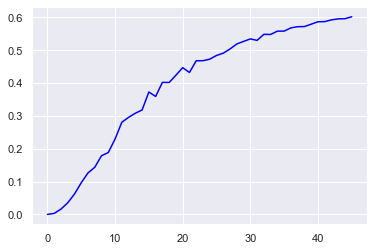

In [7]:
plt.plot(i_beta_32_06, color='blue')

In [8]:
scio.savemat('./i_beta_32_06.mat', {'i_beta_32_06': i_beta_32_06})